In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from importlib import reload

import nlp_functions as NF

from sentence_transformers import SentenceTransformer

from sklearn.svm import SVC
from sklearn.metrics import pairwise_distances
from sklearn.naive_bayes import BernoulliNB

from constants import DATA_DIR, RNG, RANDOM_SEED

In [ ]:
def distance_cluster(df, encoded, known):
    # Assign Clusters Based on Prototypes
    distances = pairwise_distances(encoded[known], encoded[~known])
    dmax = np.max(distances)
    dmin = np.min(distances)
    nearest = np.argmin(distances, axis=0)
    prob = 1-(np.min(distances, 0)-dmin)/(dmax-dmin)

    # Get labels of nearest labeled points
    pred_labels = df.loc[known, 'relevant'].values[nearest]
    return pred_labels, np.vstack((prob, prob)).T # np.ones((len(pred_labels), 2)) # *0.75


def model_fit_predict(model, df, encoded, known):
    try:
        # Provide random seed for reproducibility, if relevent
        M = model(random_state=RANDOM_SEED, probability=True)
    except TypeError:
        M = model()
    M.fit(encoded[known], df.loc[known, 'relevant'].astype(int))

    return M.predict(encoded[~known]), M.predict_proba(encoded[~known])


def ensemble_fit_predict(df, encoded):
    # "relevant" column contains manually generated labels for training
    # "labeled" column contains both manually generated and predicted labels

    models = [distance_cluster, SVC, BernoulliNB]

    known = ~df['relevant'].isna()

    preds = []
    probs = []
    for i, model in enumerate(models):
        if i == 0:
            pred, prob = model(df, encoded, known)
        else:
            pred, prob = model_fit_predict(model, df, encoded, known)
        preds.append(pred)
        probs.append(prob)

    df['labeled'] = False
    df.loc[known, 'labeled'] = df.loc[known, 'relevant'].astype(bool)
    df['confidence'] = np.nan #known.astype(float)
    df.loc[~known, 'confidence'] = np.max(np.mean(np.array(probs), 0), 1)
    df.loc[~known, 'labeled'] = np.mean(preds, axis=0)>0.5

In [3]:
subfolder = 'Iter1'
manual_labeled = pd.read_parquet(os.path.join(DATA_DIR, subfolder, 'partial_labeled_100.par'))
full_data = pd.read_parquet(os.path.join(DATA_DIR, 'fil_products_5rev.par'))
full_data['relevant'] = np.nan

In [4]:
full_data.loc[full_data.index.isin(manual_labeled.index), 'relevant'] = manual_labeled['relevant']

In [5]:
# Sentence Transformer
model = SentenceTransformer('all-MiniLM-L12-v2')
sent_encoded = model.encode(full_data["title"].values, convert_to_tensor=False)

In [104]:
# encoding, tokens = NF.simple_vector_encode(full_data)
# encoding.shape

In [76]:
# Train SVM on encodings and labels for manual_labeled
# and predict on unlabeled portion of full_data
ensemble_fit_predict(full_data, sent_encoded)

In [103]:
def plot_confidence(df):
    counts, bins, bars = plt.hist(df.loc[df['labeled'], 'confidence'], 50, histtype='step')
    plt.hist(df.loc[~df['labeled'], 'confidence'], bins, histtype='step')
    plt.yscale('log')
    plt.xlabel('Confidence')
    plt.ylabel('Count (log)')
    plt.title('Predicted Label Confidence')
    plt.legend(['Relevant', 'Irrelevant'])
    plt.gcf().set_size_inches(5, 2.5)
    plt.show()

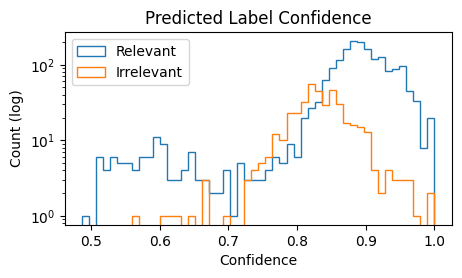

In [104]:
plot_confidence(full_data)

In [71]:
sum(full_data['confidence']<0.75)

126

In [94]:
import ipywidgets as widgets
from functools import partial


class WidgetEntry:
    def __init__(self, text="", target=None, clickfunc=None):
        self.target = target
        self.clickfunc = clickfunc

        self.text = widgets.Output()
        with self.text:
            print(text)

        self.rel_check = widgets.ToggleButton(True, description="Relevant")
        if self.clickfunc:
            self.rel_check.observe(partial(self.clickfunc, self.target), 'value')

        self.layout = widgets.HBox([self.rel_check, self.text])

        self.hide()

    def reset(self):
        self.text.clear_output()
        self.rel_check._click_handlers = widgets.CallbackDispatcher()

    def show(self):
        self.text.layout.display = ""
        self.rel_check.layout.display = ""

    def hide(self):
        self.text.layout.display = "none"
        self.rel_check.layout.display = "none"


def manual_individual_review(titles, labels):
    def _process_target(target, state, *args):
        labels[target] = state['new']

    header = widgets.Text()
    header.value = f"{len(titles)} Entries:"

    entries = [
        WidgetEntry(f"#{j}: {titles[i]}", i, _process_target)
        for j, i in enumerate(np.argsort(titles))
    ]
    main_layout = widgets.VBox([header] + [e.layout for e in entries])

    for e in entries:
        e.show()

    return main_layout

In [92]:
low_conf_rel_idxs = (full_data['confidence']<0.75)*(full_data['labeled'])
low_conf_irr_idxs = (full_data['confidence']<0.75)*(~full_data['labeled'])

low_confidence_titles = full_data.loc[low_conf_rel_idxs, 'title'].tolist() + full_data.loc[low_conf_irr_idxs, 'title'].tolist()
expected_labels = np.array([1]*sum(low_conf_rel_idxs) + [0]*sum(low_conf_irr_idxs))

In [95]:
labeled_low_conf = np.ones((len(low_confidence_titles)))
manual_individual_review(low_confidence_titles, labeled_low_conf)

In [165]:
misclassified = sum(expected_labels != labeled_low_conf)
misclassified

np.int64(16)

In [167]:
np.array(low_confidence_titles)[expected_labels != labeled_low_conf]

array(['Creality Ender 3 V2 3D Printer and PLA 3D Printer Filament Black',
       'Tseriact Filament Welder Splicer - 1.75mm 3D Filament Connector Easy Operate Repair Broken 3D Filament for All Kind PLA/ABS/PETG/TPU/PC/PP/Hips Material',
       'uxcell PTFE Tubing 3mm ID x 4mm OD x 2M 6.6ft for Filament PLA ABS 3D Printer',
       'Sunhokey 3D Printer Filament Detection Sensor Module Filament Run-Out Pause Detecting Monitor for 3D Printer Lerdge Board 1.75mm PLA ABS Filament (1.75mm, Black, 2)',
       'NanHong roll outThe New 3D Pen Filament Refills Storage Box Kit 6 Glow in The Dark Colors 1.75mm pla.36 Colors/16 Feet Each Colors Kit,590 Linear Feet Total of',
       'ELEGOO Neptune 3D Printer FDM 3D Printer Full Metal Print Size 8”x8”x8” Compatible with TPU/PLA/ABS Filament',
       'Blusmart 3D Printing Pen Ver.2015 ABS/PLA 1.75mm Printer Filament with 0.7mm Nozzle for 3D Craft Drawing (Blue)',
       'da Vinci Mini Wireless 3D Printer-6"x6"x6" Volume (Includes: 300g Filament, PLA/

In [126]:
data_manual_low_conf = full_data.copy(deep=True)
data_manual_low_conf['relevant'] = np.nan
data_manual_low_conf.loc[data_manual_low_conf.index.isin(manual_labeled.index), 'relevant'] = manual_labeled['relevant']
data_manual_low_conf.loc[low_conf_rel_idxs, 'relevant'] = labeled_low_conf[:sum(low_conf_rel_idxs)]
data_manual_low_conf.loc[low_conf_irr_idxs, 'relevant'] = labeled_low_conf[sum(low_conf_rel_idxs):]
data_manual_low_conf

,main_category,title,average_rating,rating_number,features,description,price,store,categories,details,first_available,review_count,relevant,labeled,confidence
parent_asin,,,,,,,,,,,,,,,
B079FN3D86,Industrial & Scientific,[Open Filament] da Vinci Super 3D Printer & Up...,2.9,6,"[""Open filament system: the da Vinci super has...",[],2782.74,XYZprinting,"[""Industrial & Scientific"",""Additive Manufactu...",{},NaT,5.0,NaN,False,0.848594
B073MRVXN5,Industrial & Scientific,Dremel DigiLab 3D45-01 3D Printer with Filamen...,4.4,573,"[""ADVANCED 3D PRINTING: The Dremel Digilab 3D4...","[""Dremel, your go-to brand for all your 3D pri...",1999.00,Dremel,"[""Industrial & Scientific"",""Additive Manufactu...","{""Brand"":""Dremel"",""Material"":""Abs"",""Color"":""Bl...",2017-07-01,379.0,NaN,False,0.794276
B07KGTF7QS,Industrial & Scientific,Dremel DigiLab 3D40-FLX-01 3D Printer with Fil...,4.6,90,"[""THE FLEXIBLE OPTION: Designed for a truly se...","[""Dremel, your go-to brand for all your 3D pri...",1499.00,Dremel,"[""Industrial & Scientific"",""Additive Manufactu...","{""Brand"":""Dremel"",""Material"":""Metal"",""Color"":""...",2019-01-15,42.0,NaN,False,0.781418
B01N374ZFS,Industrial & Scientific,"STANLEY Model 1 3D Printer, Heated Printer Bed...",4.0,15,"[""Automatically loads and unloads the printing...",[],799.99,Stanley,"[""Industrial & Scientific"",""Additive Manufactu...","{""Brand"":""STANLEY"",""Material"":""PLA and ABS"",""C...",2017-03-25,7.0,NaN,False,0.811664
B079KZQ69C,Industrial & Scientific,DOBOT MOOZ - 3D Printer 3 in 1 Industrial Grad...,3.2,21,"[""Full Aluminum 3D Printer with Industrial-gra...","[""Shipping List:1. Mooz Double Z-axis 3D Print...",754.38,Dobot,"[""Industrial & Scientific"",""Additive Manufactu...","{""Brand"":""DOBOT"",""Material"":""Aluminum,Pla"",""Co...",2018-02-04,6.0,NaN,False,0.807570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B08V5KFB26,Office Products,"SainSmart 1.75mm Nylon Filament, ePA-GF Glass ...",4.6,2,"[""[Incredible Strong] Take prototyping to the ...","[""OVERVIEW"",""The Nylon Filament Blended with G...",NaN,SainSmart,"[""Industrial & Scientific"",""Additive Manufactu...","{""Manufacturer"":""SainSmart"",""Brand"":""SainSmart...",2021-01-27,5.0,NaN,True,0.830847
B09VGCYV7V,Office Products,"NHH PLA Filament 1.75mm, 3D Printer Consumable...",3.6,9,"[""PLA Matte as extension of our PLA portfolio,...","[""Polylactic Acid"",""PLA is an easy-to-use biod...",NaN,NHH,"[""Industrial & Scientific"",""Additive Manufactu...","{""Manufacturer"":""NHH"",""Brand"":""NHH"",""Item Weig...",2022-03-29,5.0,NaN,True,0.879074
B0BNNP5ZST,Office Products,"Silk PLA Filament 1.75mm,ENISINA Silk Dual Col...",4.8,342,"[""Printing temperature: The recommended printi...",[],NaN,Enisina,"[""Industrial & Scientific"",""Additive Manufactu...","{""Manufacturer"":""Shenzhen Eryone Technology Co...",2022-12-01,5.0,NaN,True,0.872555


In [130]:
ensemble_fit_predict(data_manual_low_conf, sent_encoded)

In [149]:
data_manual_low_conf['relevant'] = data_manual_low_conf['relevant'].astype(float)

In [150]:
data_manual_low_conf['relevant'].value_counts(dropna=False)

relevant
NaN    2120
1.0     555
0.0     107
Name: count, dtype: int64

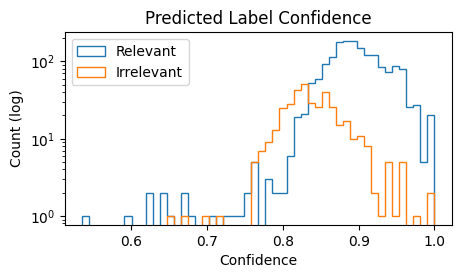

In [151]:
plot_confidence(data_manual_low_conf)

In [163]:
low_conf_rel_idxs2 = (data_manual_low_conf['confidence']<0.75)*(data_manual_low_conf['labeled'])
low_conf_irr_idxs2 = (data_manual_low_conf['confidence']<0.75)*(~data_manual_low_conf['labeled'])

low_confidence_titles2 = data_manual_low_conf.loc[low_conf_rel_idxs2, 'title'].tolist() + data_manual_low_conf.loc[low_conf_irr_idxs2, 'title'].tolist()
low_confidence_titles2

['Gizmo Dorks ABS Filament for 3D Printers 1.75mm 5kg, Black',
 '2.85mm 3D Printing Filament Connector Gen2 3D Printer Accessories Easy Operate for Filament 2.85mm PLA/ABS/PC/PETG/TPU Material…',
 'Open Smart Tag for XYZPrinting 3D Printers Compatible with 3rd Party Filament Open Source 3D Printing Filaments with Different Materials PLA PETG ABS Carbon',
 '6 Pieces 3D Printer Filament Bundle 1.75mm PLA Printing PEGT, Silk Material Each Roll 200g Vacuum Packaging Printing Filament Dryer Rainbow Filament Supplies(Modern Colors,PLA)',
 '3Doodler Create PLA 3D Printing Filament Refill Bag (x250 Strands, Over 2000 ft. of Extruded Plastic) - Bud & Bloom',
 '3D Pen Filament with Silicon Design Mat and Compatible Stencils Book with 12 Templates - 1.75mm PLA Plastic Refills - 360 Feet of Assorted Filament for 3D Drawing and Doodling',
 'Pomatoy 10x7ft Golf Practice Net High-Precision Diameter Pen PLA Filament for 3D Printer, Smooth Printing Refills for Easy 3D Art, Safe for Kids',
 '3D Pen Fila

In [152]:
relevant_prods = data_manual_low_conf.index[data_manual_low_conf['labeled']]

In [153]:
NF.print_cat_statistics(data_manual_low_conf, 'labeled')

True: 2291 (82.4%)
False: 491 (17.6%)


In [154]:
data_manual_low_conf.loc[data_manual_low_conf['labeled'], :].to_parquet(os.path.join(DATA_DIR, 'relevant_products.par'))
data_manual_low_conf.loc[~data_manual_low_conf['labeled'], :].to_parquet(os.path.join(DATA_DIR, 'irrelevant_products.par'))

In [155]:
with open(os.path.join(DATA_DIR, 'relevant_prods.csv'), 'w') as f:
    f.write(','.join([str(v) for v in relevant_prods]))

In [156]:
reviews = pd.read_parquet(os.path.join(DATA_DIR, 'reviews.par'))

In [157]:
relevant_reviews = reviews.loc[reviews['parent_asin'].isin(relevant_prods)]

In [158]:
relevant_reviews.to_parquet(os.path.join(DATA_DIR, 'relevant_reviews.par'))

In [159]:
len(relevant_reviews)

119105

In [160]:
vocab_map = {v:k for k,v in model.tokenizer.vocab.items()}
token_ids = model.tokenizer(data_manual_low_conf.loc[data_manual_low_conf['labeled'], 'title'].values.tolist())['input_ids']

words = []
for sentence in token_ids:
    words.extend([vocab_map[word] for word in sentence])

values, counts = np.unique(words, return_counts=True)
word_usage = pd.DataFrame({'values': values, 'counts': counts})
word_usage.sort_values('counts', ascending=False, inplace=True)

In [161]:
with pd.option_context('display.max_rows', 100):
    print(word_usage.head(100))

           values  counts
677             ,    5234
679             .    5079
690             1    4219
1209           fi    3679
331         ##lam    3671
192         ##ent    3630
779            3d    3401
399          ##mm    2540
68            ##a    2485
1637           pl    2438
678             -    2401
822            75    2294
851         [CLS]    2291
852         [SEP]    2291
729             2    2195
224           ##g    2082
1678      printer    2033
315           ##k    1537
673             (    1493
674             )    1492
680             /    1458
676             +    1457
1838           sp    1412
681             0    1407
449         ##ool    1400
1511           mm    1040
863      accuracy    1035
1131  dimensional     918
542           ##s     787
337          ##lb     663
1680     printing     601
1239          for     579
953         black     532
685            02     470
686            03     459
1388           kg     434
1626          pet     379
1413        